## One-Dimensional Steady Flow with Transport

phreeqc ex11



### One-Dimensional Steady Flow with Transport Problem Setup

Imports

In [1]:
import os
import sys

In [2]:
import flopy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import modflowapi
from modflowapi import Callbacks
from pathlib import Path

Append to system path to include the common subdirectory

In [4]:
sys.path.append(os.path.join("..", "common"))

Import common functionality

In [5]:
import analytical
import config
from figspecs import USGSFigure

Set figure properties specific to this problem

In [6]:
figure_size = (5, 3)

Base simulation and model name and workspace

In [7]:
ws = config.base_ws
example_name = "moc"

Scenario parameters - make sure there is at least one blank line before next item

In [8]:
parameters = {
    "ex11": {
        "longitudinal_dispersivity": 0.0,
        "retardation_factor": 1.0,
        "decay_rate": 0.0,
        "solutes":                ['Na', 'Cl', 'K', 'Ca', 'N(5)'],
        "initial_solution":       [ 1.0,  0.0, 0.2,  0.0,  1.2  ],   # mmol/kgw
        "influent_concentration": [ 0.0,  1.2, 0.0,  0.6,  0.0  ],   # mmol/kgw
    },
}

Scenario parameter units - make sure there is at least one blank line before next item
add parameter_units to add units to the scenario parameter table

In [9]:
parameter_units = {
    "longitudinal_dispersivity": "$m$",
    "retardation_factor": "unitless",
    "decay_rate": "$s^{-1}$",
}

Model units

In [10]:
length_units = "METERS"    # m
time_units = "seconds"     # s

Table of model parameters

In [11]:
nper = 1                      # Number of periods
nlay = 1                      # Number of layers
nrow = 1                      # Number of rows
ncol = 40                     # Number of columns
system_length = .08           # Length of system ($m$)
delr = 0.002                  # Column width ($m$)
delc = 1.0                    # Row width ($m$)
top = 1.0                     # Top of the model ($m$)
botm = 0                      # Layer bottom elevation ($m$)
specific_discharge = 1./720.  # Specific discharge ($m s^{-1}$)
hydraulic_conductivity = 1.0  # Hydraulic conductivity ($m s^{-1}$)
porosity = 1.0                # Porosity of mobile domain (unitless)
total_time = 14400.0          # Simulation time ($s$)

### Functions to build, write, run, and plot models

MODFLOW 6 flopy GWF simulation object (sim) is returned


In [12]:
def get_sorption_dict(retardation_factor):
    sorption = None
    bulk_density = None
    distcoef = None
    if retardation_factor > 1.0:
        sorption = "linear"
        bulk_density = 1.0
        distcoef = (retardation_factor - 1.0) * porosity / bulk_density
    sorption_dict = {
        "sorption": sorption,
        "bulk_density": bulk_density,
        "distcoef": distcoef,
    }
    return sorption_dict

In [13]:
def get_decay_dict(decay_rate, sorption=False):
    first_order_decay = None
    decay = None
    decay_sorbed = None
    if decay_rate != 0.0:
        first_order_decay = True
        decay = decay_rate
        if sorption:
            decay_sorbed = decay_rate
    decay_dict = {
        "first_order_decay": first_order_decay,
        "decay": decay,
        "decay_sorbed": decay_sorbed,
    }
    return decay_dict

In [14]:
def build_mf6gwf(sim_folder, solutes, influent_concentration):
    # print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 1, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [
            [
                (0, 0, 0),
                specific_discharge * delc * delr,   # m^3/s
                *influent_concentration,
            ]
        ],
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=solutes
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    
    # set vars for use in run_model
    sim.sim_ws = sim_ws

    return sim

MODFLOW 6 flopy GWF simulation object (sim) is returned

In [15]:
def build_mf6gwt(sim_folder, solute, initial_solution, longitudinal_dispersivity, retardation_factor, decay_rate):
    # print(f"Building mf6gwt_{solute} model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(ws, sim_folder, f"mf6gwt_{solute}")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 240, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=initial_solution, filename=f"{name}.ic")
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        **get_sorption_dict(retardation_factor),
        **get_decay_dict(decay_rate, retardation_factor > 1.0),
    )
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=longitudinal_dispersivity,
        ath1=longitudinal_dispersivity,
    )
    pd = [
        ("GWFHEAD", f"../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [["WEL-1", "AUX", solute]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    obs_data = {
        f"{solute}.obs.csv": [
            ("CELL00", "CONCENTRATION", (0, 0, 0)),
            ("CELL01", "CONCENTRATION", (0, 0, 1)),
            ("CELL02", "CONCENTRATION", (0, 0, 2)),
            ("CELL03", "CONCENTRATION", (0, 0, 3)),
            ("CELL04", "CONCENTRATION", (0, 0, 4)),
            ("CELL05", "CONCENTRATION", (0, 0, 5)),
            ("CELL06", "CONCENTRATION", (0, 0, 6)),
            ("CELL07", "CONCENTRATION", (0, 0, 7)),
            ("CELL08", "CONCENTRATION", (0, 0, 8)),
            ("CELL09", "CONCENTRATION", (0, 0, 9)),
            ("CELL10", "CONCENTRATION", (0, 0, 10)),
            ("CELL11", "CONCENTRATION", (0, 0, 11)),
            ("CELL12", "CONCENTRATION", (0, 0, 12)),
            ("CELL13", "CONCENTRATION", (0, 0, 13)),
            ("CELL14", "CONCENTRATION", (0, 0, 14)),
            ("CELL15", "CONCENTRATION", (0, 0, 15)),
            ("CELL16", "CONCENTRATION", (0, 0, 16)),
            ("CELL17", "CONCENTRATION", (0, 0, 17)),
            ("CELL18", "CONCENTRATION", (0, 0, 18)),
            ("CELL19", "CONCENTRATION", (0, 0, 19)),
            ("CELL20", "CONCENTRATION", (0, 0, 20)),
            ("CELL21", "CONCENTRATION", (0, 0, 21)),
            ("CELL22", "CONCENTRATION", (0, 0, 22)),
            ("CELL23", "CONCENTRATION", (0, 0, 23)),
            ("CELL24", "CONCENTRATION", (0, 0, 24)),
            ("CELL25", "CONCENTRATION", (0, 0, 25)),
            ("CELL26", "CONCENTRATION", (0, 0, 26)),
            ("CELL27", "CONCENTRATION", (0, 0, 27)),
            ("CELL28", "CONCENTRATION", (0, 0, 28)),
            ("CELL29", "CONCENTRATION", (0, 0, 29)),
            ("CELL30", "CONCENTRATION", (0, 0, 30)),
            ("CELL31", "CONCENTRATION", (0, 0, 31)),
            ("CELL32", "CONCENTRATION", (0, 0, 32)),
            ("CELL33", "CONCENTRATION", (0, 0, 33)),
            ("CELL34", "CONCENTRATION", (0, 0, 34)),
            ("CELL35", "CONCENTRATION", (0, 0, 35)),
            ("CELL36", "CONCENTRATION", (0, 0, 36)),
            ("CELL37", "CONCENTRATION", (0, 0, 37)),
            ("CELL38", "CONCENTRATION", (0, 0, 38)),
            ("CELL39", "CONCENTRATION", (0, 0, 39)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    
    # set vars for use in run_model
    sim.sim_ws = sim_ws
    sim.solute = solute
    
    return sim

In [16]:
def build_model(sim_name, solutes, initial_solution, influent_concentration, longitudinal_dispersivity, retardation_factor, decay_rate):
    sims = None
    if config.buildModel:
        sim_mf6gwf = build_mf6gwf(sim_name, solutes, influent_concentration)
        sims = (sim_mf6gwf,)
        for i, solute in enumerate(solutes):
            sim_mf6gwt = build_mf6gwt(
                sim_name, solute, initial_solution[i], longitudinal_dispersivity, retardation_factor, decay_rate
                )
            sims = sims + (sim_mf6gwt,)
    return sims

Function to write model files

In [17]:
def write_model(sims, silent=True):
    if config.writeModel:
        sim_mf6gwf, *sim_mf6gwts = sims
        sim_mf6gwf.write_simulation(silent=silent)
        for sim_mf6gwt in sim_mf6gwts:
            sim_mf6gwt.write_simulation(silent=silent)
    return

In [18]:
def callback_function(sim, callback_step):
    """
    A demonstration function that dynamically adjusts recharge
    and pumping in a modflow-6 model through the MODFLOW-API
    
    Parameters
    ----------
    sim : modflowapi.ApiSimulation
        A simulation object for the solution group that is 
        currently being solved
    step : enumeration
        modflowapi.Callbacks enumeration object that indicates
        the part of the solution modflow is currently in.
    """
    if callback_step == Callbacks.initialize:
        #print("callback_step == Callbacks.initialize")
        #print(sim)
        pass
    
    if callback_step == Callbacks.stress_period_start:
        #print("callback_step == Callbacks.stress_period_start")
        #print(sim)
        pass
    
    if callback_step == Callbacks.timestep_start:
        #print("callback_step == Callbacks.timestep_start")
        #print(sim)
        pass
        
    if callback_step == Callbacks.iteration_start:
        #print("callback_step == Callbacks.iteration_start")
        #print(sim)
        pass


Function to run the model
True is returned if the model runs successfully

In [19]:
@config.timeit
def run_model(sims, silent=True):
    success = True
    if config.runModel:
        success = False
        sim_mf6gwf, *sim_mf6gwts = sims
        success, buff = sim_mf6gwf.run_simulation(silent=silent)
        if not success:
            print(buff)
            return success
        for sim_mf6gwt in sim_mf6gwts:
            success, buff = sim_mf6gwt.run_simulation(silent=silent)
            if not success:
                print(buff)
                return success
    return success

In [20]:
@config.timeit
def run_model_api_inline_run_simulation(sims, silent=True):
    success = True
    if config.runModel:
        # @todo update for other OSs
        libmf6 = Path(os.path.join(os.environ["USERPROFILE"], "AppData\\Local\\flopy\\bin", "libmf6"))
        #success = False
        sim_mf6gwf, *sim_mf6gwts = sims        
        sim_ws = sim_mf6gwf.sim_ws
        
        #
        # emulate modflowapi.run_simulation(dll, sim_ws, callback_function, verbose=False)
        #
        callback = callback_function
        verbose = False
        _develop = False
        
        mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_ws)
        
        if verbose:
            version = mf6.get_version()
            print(f"MODFLOW-6 API Version {version}")
            print("Initializing MODFLOW-6 simulation")
                
        mf6.initialize()

        sim = modflowapi.extensions.ApiSimulation.load(mf6)
        
        if _develop:
            with open(f"{sim_mf6gwf.sim_ws}/var_list.txt", "w") as foo:
                for name in mf6.get_input_var_names():
                    foo.write(f"{name}\n")
                    
        has_converged = False
        current_time = mf6.get_current_time()
        end_time = mf6.get_end_time()
        kperold = [0 for _ in range(sim.subcomponent_count)]
        
        while current_time < end_time:
            dt = mf6.get_time_step()
            mf6.prepare_time_step(dt)

            if verbose:
                print(
                    f"Solving: Stress Period {sim.kper + 1}; "
                    f"Timestep {sim.kstp + 1}"
                )

            for sol_id, slnobj in sorted(sim.solutions.items()):
                models = {}
                maxiter = slnobj.mxiter
                solution = {sol_id: slnobj}
                for model in sim.models:
                    if sol_id == model.solution_id:
                        models[model.name.lower()] = model

                sim_grp = modflowapi.extensions.ApiSimulation(
                    mf6, models, solution, sim._exchanges, sim.tdis, sim.ats
                )
                mf6.prepare_solve(sol_id)
                if sim.kper != kperold[sol_id - 1]:
                    callback(sim_grp, Callbacks.stress_period_start)
                    kperold[sol_id - 1] += 1
                elif current_time == 0:
                    callback(sim_grp, Callbacks.stress_period_start)

                kiter = 0
                callback(sim_grp, Callbacks.timestep_start)

                if sim_grp.ats_period[0]:
                    mindt = sim_grp.ats_period[-1]
                    while sim_grp.delt > mindt:
                        sim_grp.iteration = kiter
                        callback(sim_grp, Callbacks.iteration_start)
                        has_converged = mf6.solve(sol_id)
                        callback(sim_grp, Callbacks.iteration_end)
                        kiter += 1
                        if has_converged and sim_grp.allow_convergence:
                            break

                else:
                    while kiter < maxiter:
                        sim_grp.iteration = kiter
                        callback(sim_grp, Callbacks.iteration_start)
                        has_converged = mf6.solve(sol_id)
                        callback(sim_grp, Callbacks.iteration_end)
                        kiter += 1
                        if has_converged and sim_grp.allow_convergence:
                            break

                callback(sim_grp, Callbacks.timestep_end)
                mf6.finalize_solve(sol_id)

            mf6.finalize_time_step()
            current_time = mf6.get_current_time()

            if not has_converged:
                print(f"Simulation group: {sim_grp} DID NOT CONVERGE")

            if sim_grp.nstp == sim_grp.kstp + 1:
                callback(sim_grp, Callbacks.stress_period_end)

        try:
            mf6.finalize()
        except Exception:
            raise RuntimeError("MF6 simulation failed, check listing file")
        print("(mf6gwf) NORMAL TERMINATION OF SIMULATION")
        
        #
        # Now run transport models
        #
        
        for sim_mf6gwt in sim_mf6gwts:
            sim_ws = sim_mf6gwt.sim_ws
            solute = sim_mf6gwt.solute
            mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_ws)

            mf6.initialize()

            sim = modflowapi.extensions.ApiSimulation.load(mf6)

            if _develop:
                with open(f"{sim_mf6gwt.sim_ws}/var_list.txt", "w") as foo:
                    for name in mf6.get_input_var_names():
                        foo.write(f"{name}\n")

            has_converged = False
            current_time = mf6.get_current_time()
            end_time = mf6.get_end_time()
            kperold = [0 for _ in range(sim.subcomponent_count)]

            while current_time < end_time:
                dt = mf6.get_time_step()
                mf6.prepare_time_step(dt)

                if verbose:
                    print(
                        f"Solving: Stress Period {sim.kper + 1}; "
                        f"Timestep {sim.kstp + 1}"
                    )

                for sol_id, slnobj in sorted(sim.solutions.items()):
                    models = {}
                    maxiter = slnobj.mxiter
                    solution = {sol_id: slnobj}
                    for model in sim.models:
                        if sol_id == model.solution_id:
                            models[model.name.lower()] = model

                    sim_grp = modflowapi.extensions.ApiSimulation(
                        mf6, models, solution, sim._exchanges, sim.tdis, sim.ats
                    )
                    mf6.prepare_solve(sol_id)
                    if sim.kper != kperold[sol_id - 1]:
                        callback(sim_grp, Callbacks.stress_period_start)
                        kperold[sol_id - 1] += 1
                    elif current_time == 0:
                        callback(sim_grp, Callbacks.stress_period_start)

                    kiter = 0
                    callback(sim_grp, Callbacks.timestep_start)

                    if sim_grp.ats_period[0]:
                        mindt = sim_grp.ats_period[-1]
                        while sim_grp.delt > mindt:
                            sim_grp.iteration = kiter
                            callback(sim_grp, Callbacks.iteration_start)
                            has_converged = mf6.solve(sol_id)
                            callback(sim_grp, Callbacks.iteration_end)
                            kiter += 1
                            if has_converged and sim_grp.allow_convergence:
                                break

                    else:
                        while kiter < maxiter:
                            sim_grp.iteration = kiter
                            callback(sim_grp, Callbacks.iteration_start)
                            has_converged = mf6.solve(sol_id)
                            callback(sim_grp, Callbacks.iteration_end)
                            kiter += 1
                            if has_converged and sim_grp.allow_convergence:
                                break

                    callback(sim_grp, Callbacks.timestep_end)
                    mf6.finalize_solve(sol_id)

                mf6.finalize_time_step()
                current_time = mf6.get_current_time()

                if not has_converged:
                    print(f"Simulation group: {sim_grp} DID NOT CONVERGE")

                if sim_grp.nstp == sim_grp.kstp + 1:
                    callback(sim_grp, Callbacks.stress_period_end)

            try:
                mf6.finalize()
            except Exception:
                raise RuntimeError("MF6 simulation failed, check listing file")
            print(f"(mf6gwt({solute})) NORMAL TERMINATION OF SIMULATION")
            
    return success

In [21]:
@config.timeit
def run_model_api_run_simulation(sims, silent=True):
    success = True
    if config.runModel:
        # @todo update for other OSs
        libmf6 = Path(os.path.join(os.environ["USERPROFILE"], "AppData\\Local\\flopy\\bin", "libmf6"))
        
        sim_mf6gwf, *sim_mf6gwts = sims        
        modflowapi.run_simulation(libmf6, sim_mf6gwf.sim_ws, callback_function, verbose=False)
        
        # @todo error checking
        for sim_mf6gwt in sim_mf6gwts:
            modflowapi.run_simulation(libmf6, sim_mf6gwt.sim_ws, callback_function, verbose=False)
    return success

In [22]:
@config.timeit
def run_model_api_bmi(sims, silent=True):
    success = True
    if config.runModel:
        # @todo update for other OSs        
        libmf6 = Path(os.path.join(os.environ["USERPROFILE"], "AppData\\Local\\flopy\\bin", "libmf6"))

        sim_mf6gwf, *sim_mf6gwts = sims        
        mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_mf6gwf.sim_ws)
        mf6.initialize()
        
        current_time = mf6.get_current_time()
        end_time = mf6.get_end_time()
        while current_time < end_time:
            mf6.update()
            current_time = mf6.get_current_time()
        mf6.finalize()
        if not silent:
            print("(mf6gwf) NORMAL TERMINATION OF SIMULATION")
        
        for sim_mf6gwt in sim_mf6gwts:
            mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_mf6gwt.sim_ws)
            mf6.initialize()
            
            current_time = mf6.get_current_time()
            end_time = mf6.get_end_time()           
            while current_time < end_time:
                mf6.update()
                current_time = mf6.get_current_time()
            mf6.finalize()
            if not silent:
                print(f"(mf6gwt({sim_mf6gwt.solute})) NORMAL TERMINATION OF SIMULATION")
    return success

In [23]:
@config.timeit
def run_model_api_xmi(sims, silent=True):
    success = True
    if config.runModel:
        # @todo update for other OSs        
        libmf6 = Path(os.path.join(os.environ["USERPROFILE"], "AppData\\Local\\flopy\\bin", "libmf6"))

        sim_mf6gwf, *sim_mf6gwts = sims        
        mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_mf6gwf.sim_ws)
        mf6.initialize()
        
        current_time = mf6.get_current_time()
        end_time = mf6.get_end_time()
        while current_time < end_time:
            dt = mf6.get_time_step()
            mf6.prepare_time_step(dt)
            # modify values here            
            mf6.do_time_step()
            # and maybe something here as well            
            mf6.finalize_time_step()            
            current_time = mf6.get_current_time()
        mf6.finalize()
        if not silent:
            print("(mf6gwf) NORMAL TERMINATION OF SIMULATION")
        
        for sim_mf6gwt in sim_mf6gwts:
            mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_mf6gwt.sim_ws)
            mf6.initialize()
            
            current_time = mf6.get_current_time()
            end_time = mf6.get_end_time()           
            while current_time < end_time:
                dt = mf6.get_time_step()
                mf6.prepare_time_step(dt)
                # modify values here
                mf6.do_time_step()
                # and maybe something here as well
                mf6.finalize_time_step()
                current_time = mf6.get_current_time()
            mf6.finalize()
            if not silent:
                print(f"(mf6gwt({sim_mf6gwt.solute})) NORMAL TERMINATION OF SIMULATION")
    return success

Function to plot the model results

In [24]:
def plot_results_ct(
    sims, idx, solutes_idx, solutes, initial_solution, influent_concentration, longitudinal_dispersivity, retardation_factor, decay_rate
):
    if config.plotModel:
        sim_mf6gwf, *sim_mf6gwts = sims
        sim_mf6gwt = sim_mf6gwts[solutes_idx]
        fs = USGSFigure(figure_type="graph", verbose=False)

        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        iskip = 5
        
        obsnames = ["CELL00", "CELL19", "CELL39"]
        simtimes = mf6gwt_ra["totim"]
        
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )
        colors=["blue", "red", "green"]
        for i, x in enumerate([0.05, 4.05, 11.05]):
            axs.plot(
                simtimes[::iskip],
                mf6gwt_ra[obsnames[i]][::iskip],
                marker="o",
                ls="none",
                mec=colors[i],
                mfc="none",
                markersize="4",
                label=obsnames[i],
            )
        axs.set_ylim(0, 1.4)
        axs.set_xlim(0, 1.2 * total_time)
        axs.set_xlabel("Time (seconds)")
        axs.set_ylabel(f"{solutes[solutes_idx]} Concentration (mmol/kgw)")            
        axs.legend()

        # save figure
        if config.plotSave:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-ct{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

In [25]:
def plot_results_cd(
    sims, idx, solutes_idx, solutes, initial_solution, influent_concentration, longitudinal_dispersivity, retardation_factor, decay_rate
):
    if config.plotModel:
        #print(f"Plotting {solutes[solutes_idx]} versus x model results...")
        sim_mf6gwf, *sim_mf6gwts = sims
        sim_mf6gwt = sim_mf6gwts[solutes_idx]
        fs = USGSFigure(figure_type="graph", verbose=False)
        
        ucnobj_mf6 = sim_mf6gwt.trans.output.concentration()        
        
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        ctimes = [14400.]
        #x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol - 1)
        x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol)
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )
        
        colors=["blue", "red", "green"]
        for i, t in enumerate(ctimes):
            simconc = ucnobj_mf6.get_data(totim=t).flatten()
            assert(len(x) == len(simconc))
            axs.plot(
                x,
                simconc,
                marker="o",
                ls="none",
                mec=colors[i],
                mfc="none",
                markersize="4",
            )
        axs.set_ylim(0, 1.4)
        #axs.set_xlim(0, .08)
        axs.set_xlim(0, 1.2 * system_length)
        if idx in [0]:
            axs.text(.070, 0.7, "t=14400 s")
        axs.set_xlabel("Distance (m)")
        axs.set_ylabel(f"{solutes[solutes_idx]} Concentration (mmol/kgw)")
        #plt.legend()

        # save figure
        if config.plotSave:
            sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-cd{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

Function that wraps all of the steps for each scenario

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.


In [26]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    
    sims = build_model(key, **parameter_dict)
    write_model(sims, silent=silent)
    #success = run_model(sims, silent=silent)
    #success = run_model_api_inline_run_simulation(sims, silent=silent)
    #success = run_model_api_run_simulation(sims, silent=silent)
    success = run_model_api_bmi(sims, silent=silent)
    #success = run_model_api_xmi(sims, silent=silent)
    
    run_model_api_inline_run_simulation
    
    if success:
        for sidx, solute in enumerate(parameter_dict["solutes"]):
            plot_results_ct(sims, idx, sidx, **parameter_dict)
            plot_results_cd(sims, idx, sidx, **parameter_dict)

In [27]:
def test_01():
    scenario(0, silent=False)

run_model_api_bmi  1,097.52 ms


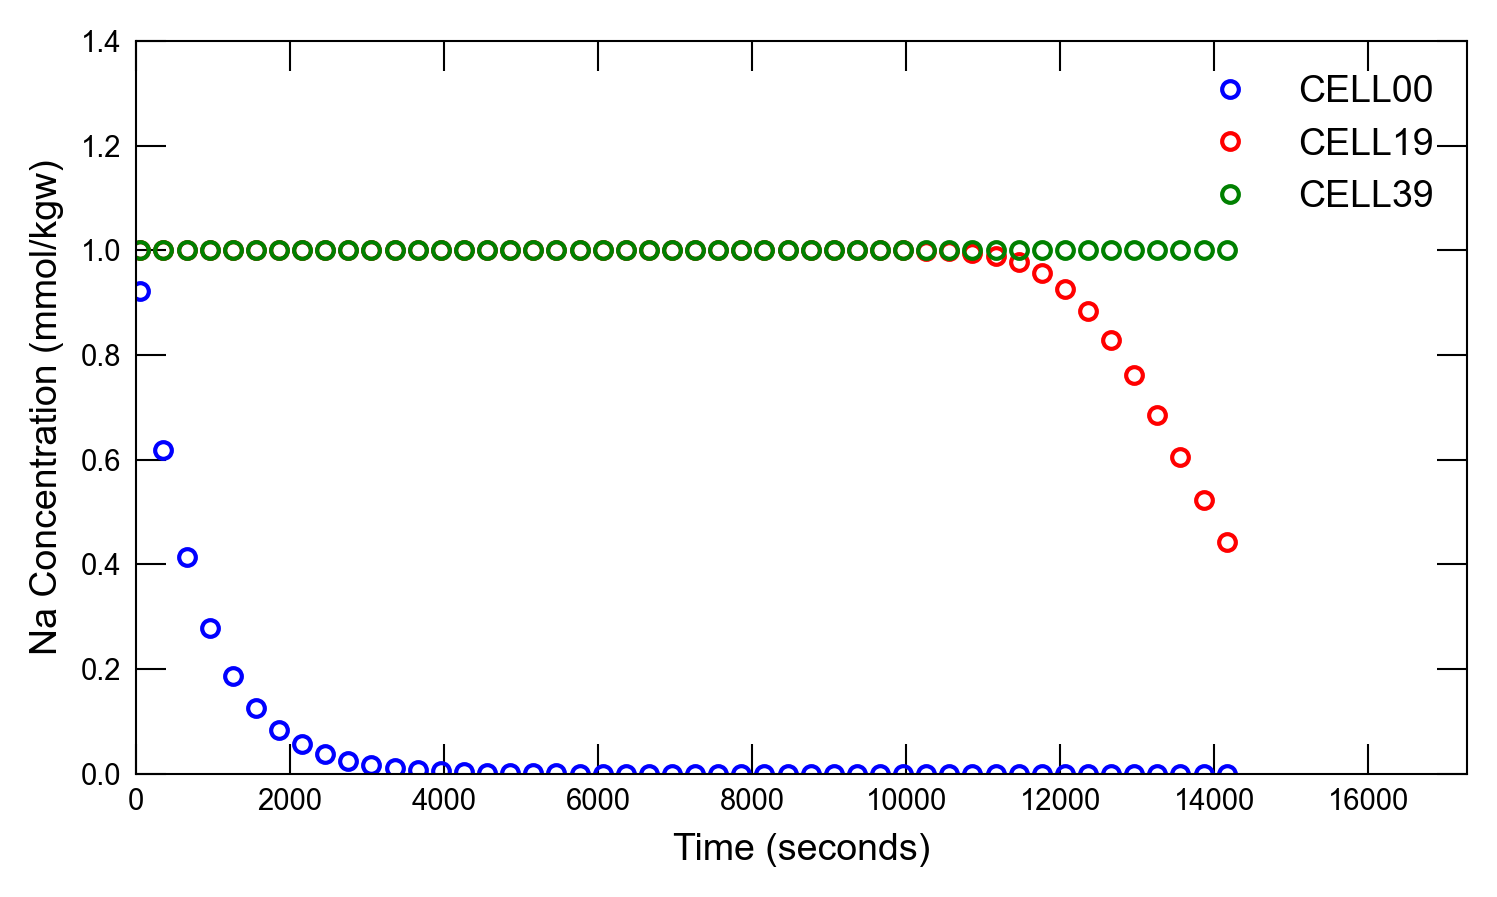

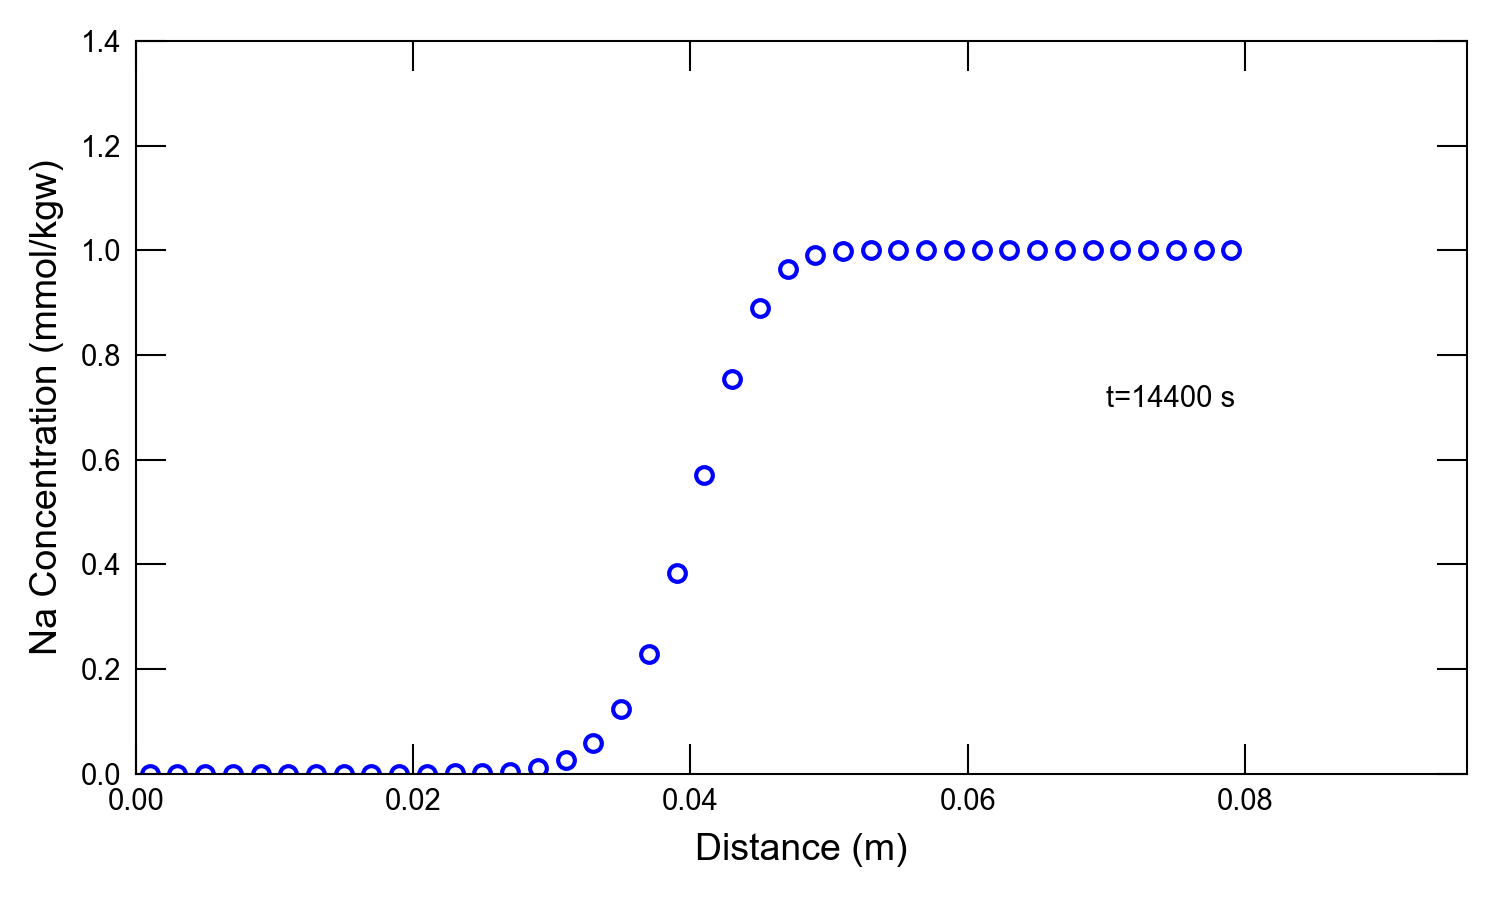

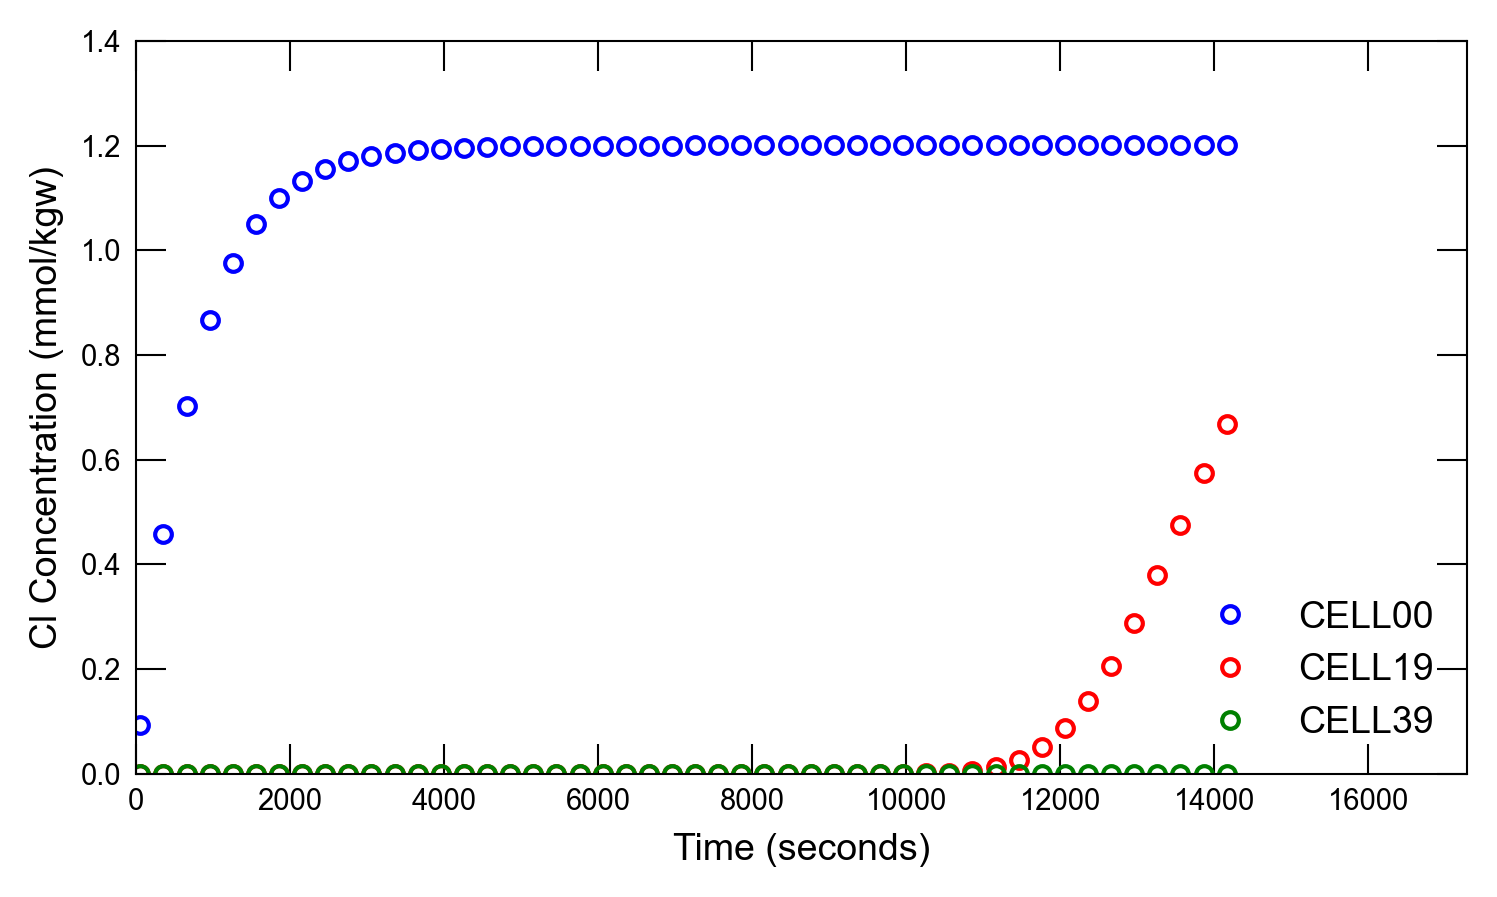

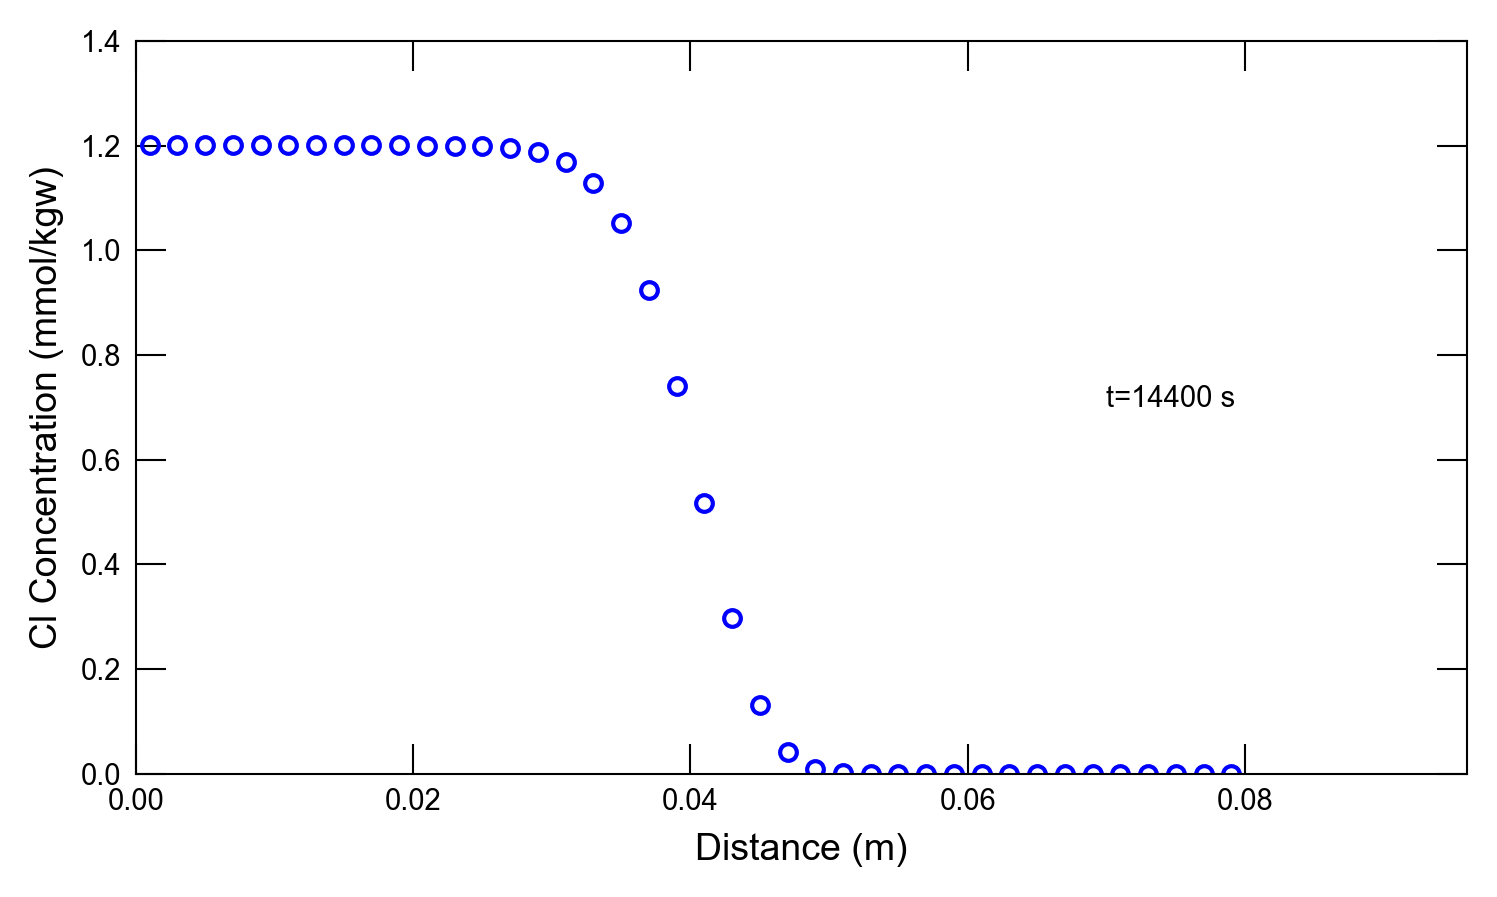

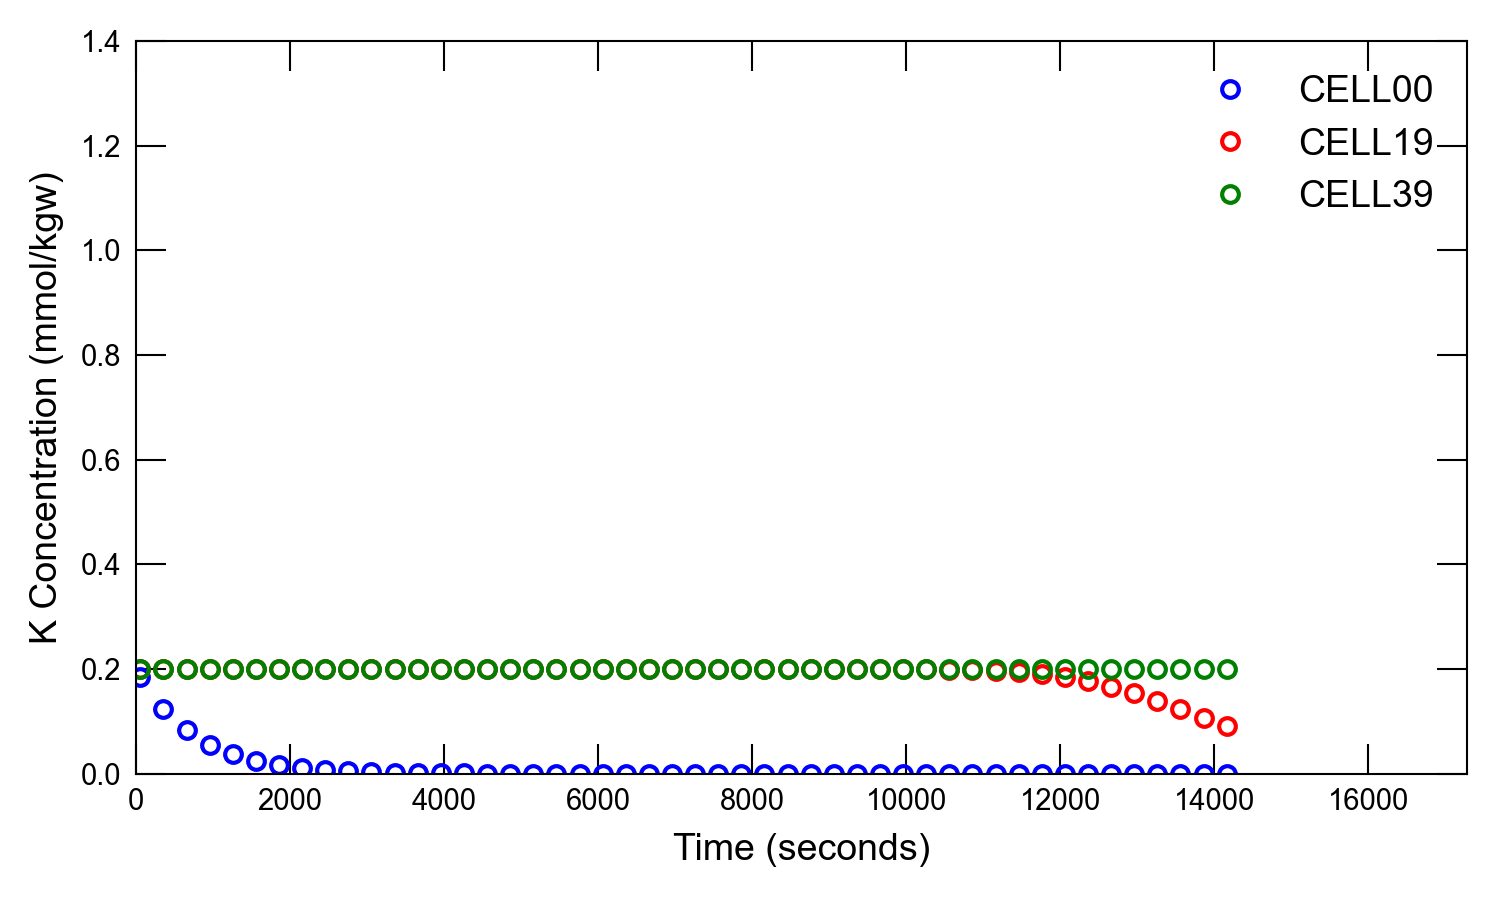

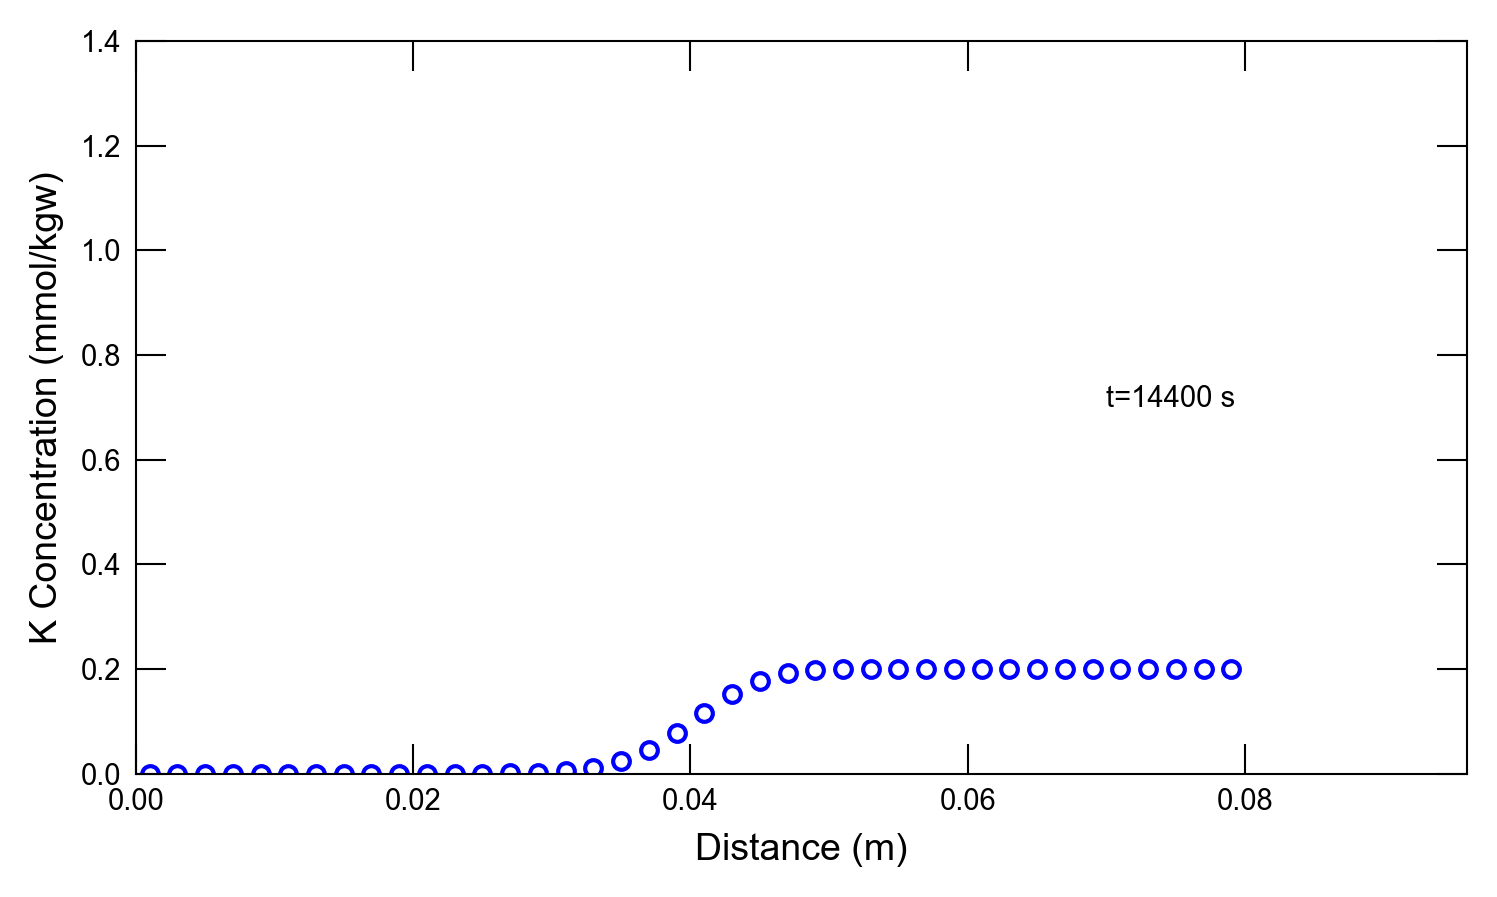

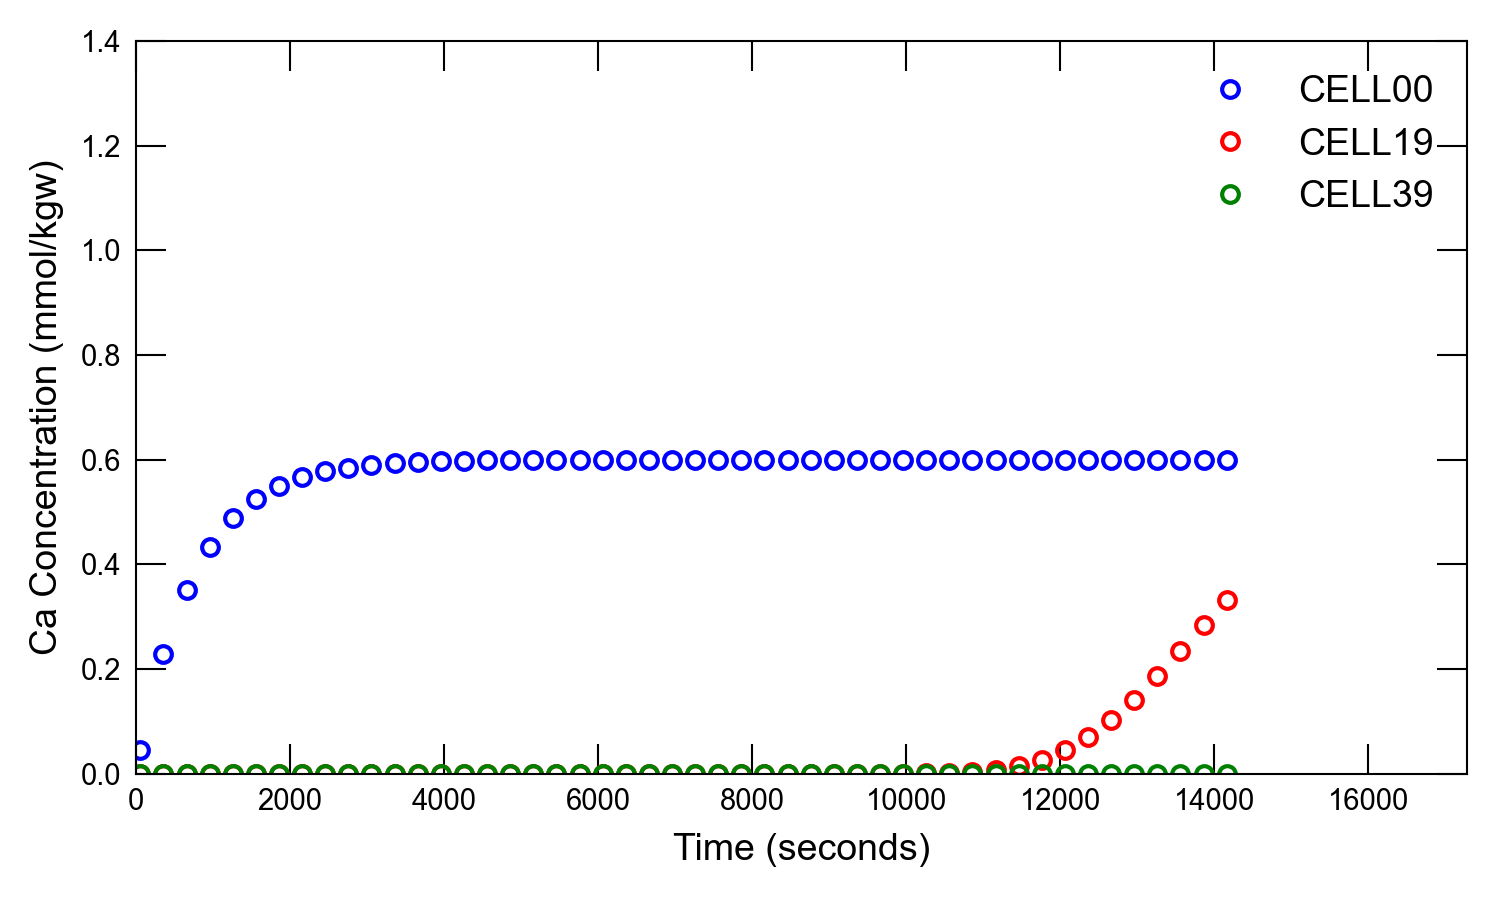

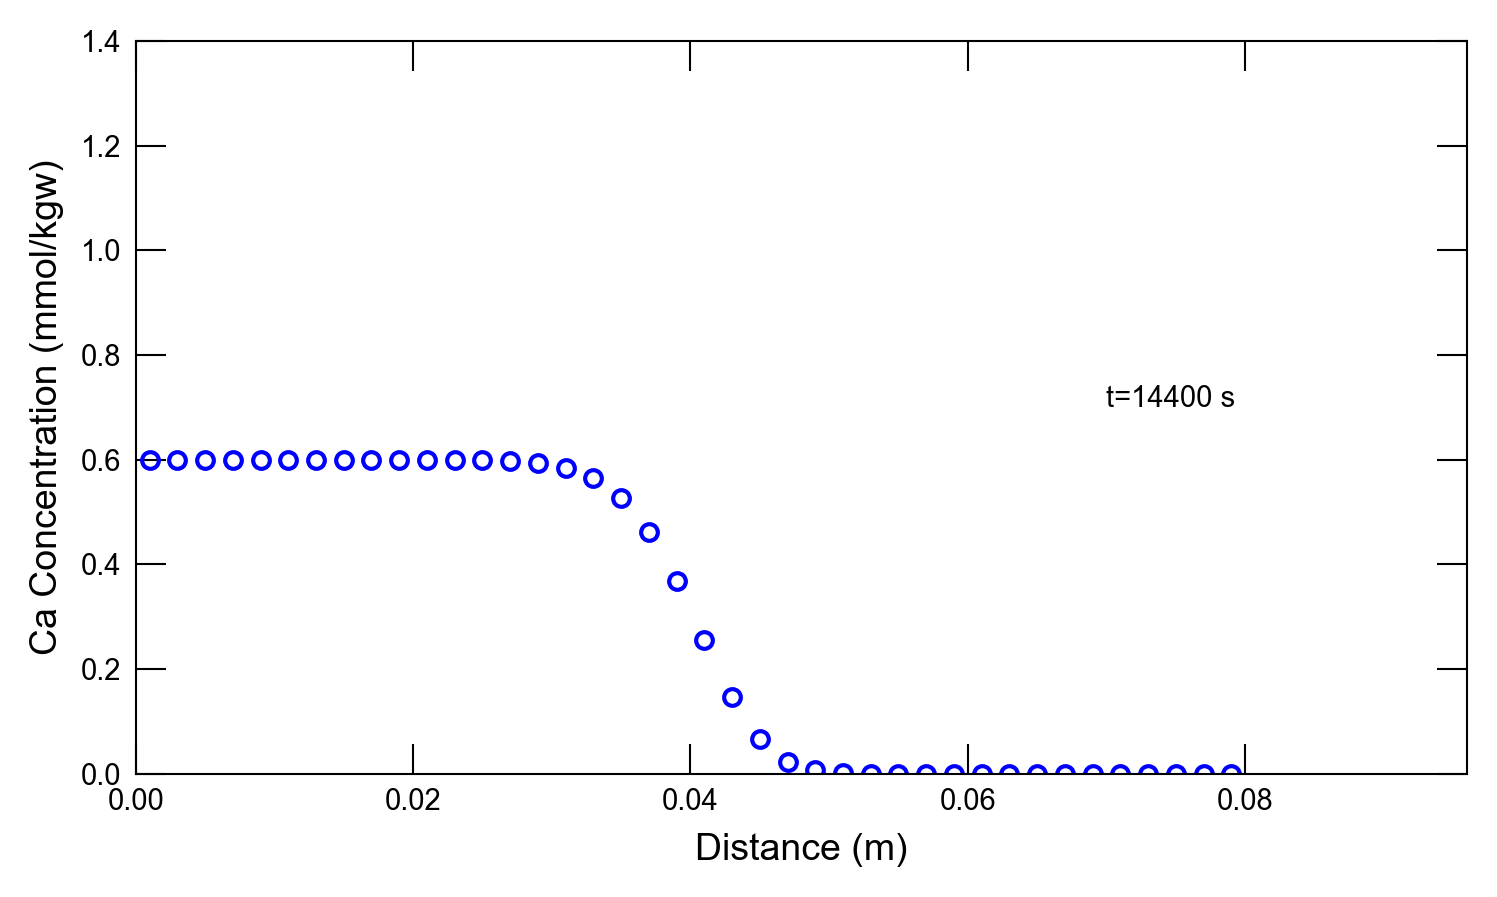

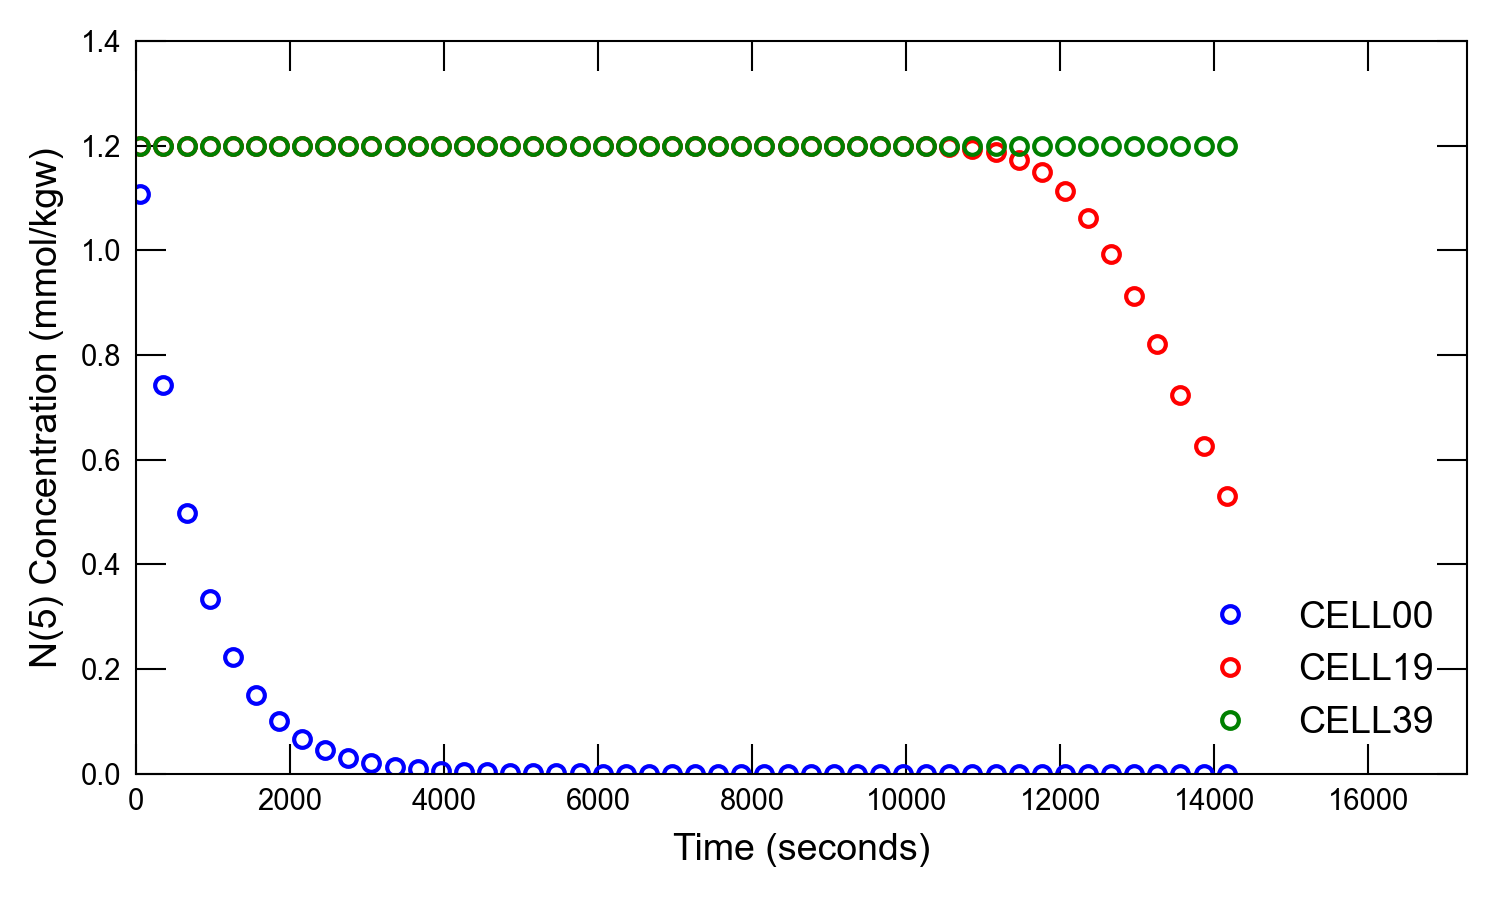

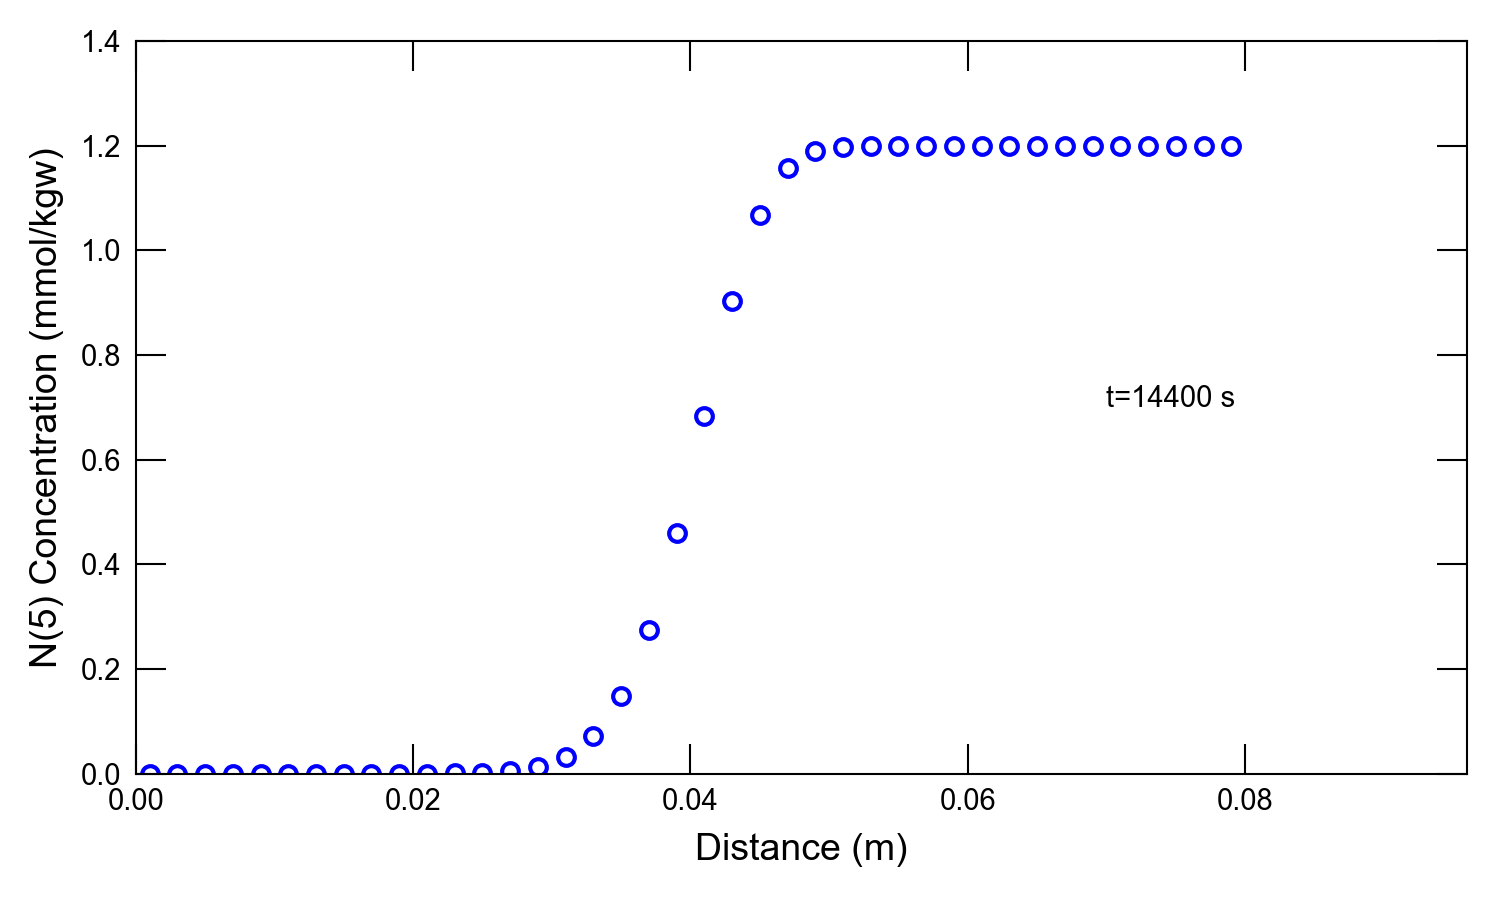

In [28]:
if __name__ == "__main__":
    scenario(0)